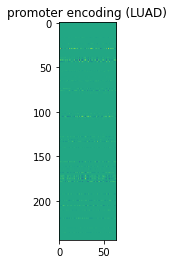

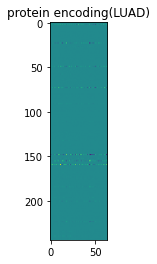

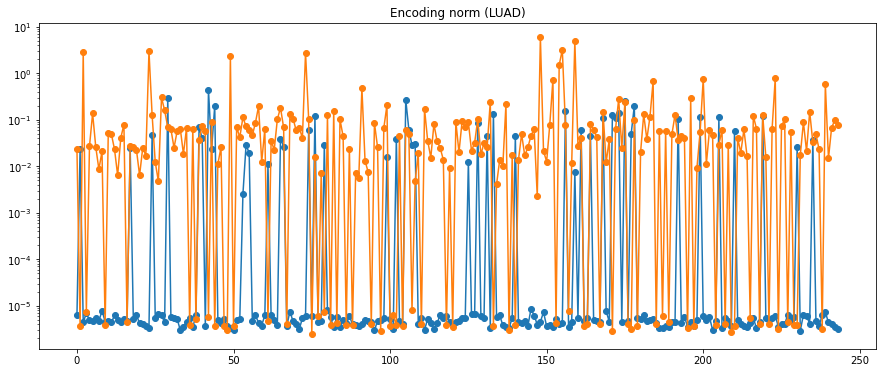

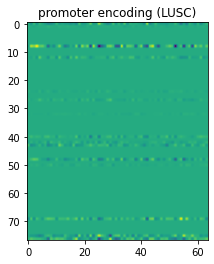

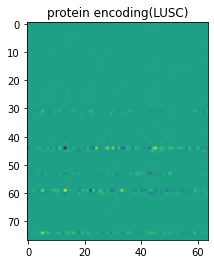

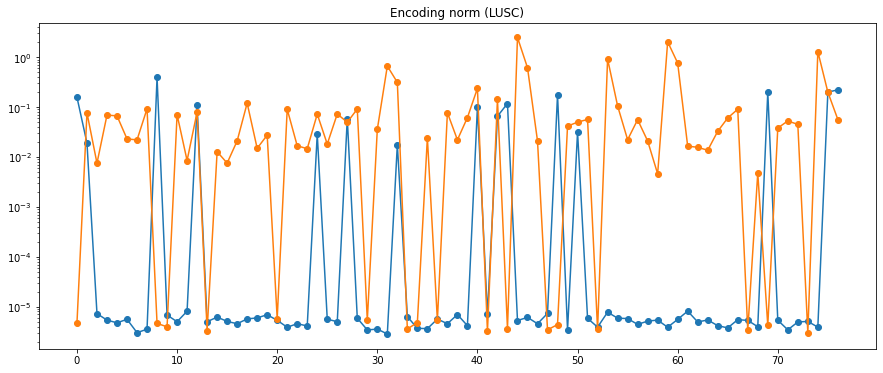

In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np


# Loading and demoing the structure of the files

filename = "/mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUAD/TCGA-17-Z025-01A-01W-0746-08.h5"

with h5py.File(filename, "r") as f:

    prom = f["data"]["promoter"][()]
    prot = f["data"]["protein"][()]

plt.imshow(prom)
plt.title("promoter encoding (LUAD)")
plt.show()

plt.imshow(prot)
plt.title("protein encoding(LUAD)")
plt.show()

# Why are some norms so small?
# Perhaps we can drop the genese were the norm is small for both promoter and the protein?
plt.figure(figsize=(15, 6))
plt.semilogy(np.abs(prom).sum(1), marker="o", label="promoter")
plt.semilogy(np.abs(prot).sum(1), marker="o", label="protein")
plt.title("Encoding norm (LUAD)")
plt.show()


# Another example

filename = "/mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUSC/TCGA-21-1078-01A-01D-1521-08.h5"

with h5py.File(filename, "r") as f:

    prom = f["data"]["promoter"][()]
    prot = f["data"]["protein"][()]

plt.imshow(prom)
plt.title("promoter encoding (LUSC)")
plt.show()

plt.imshow(prot)
plt.title("protein encoding(LUSC)")
plt.show()

plt.figure(figsize=(15, 6))
plt.semilogy(np.abs(prom).sum(1), marker="o", label="promoter")
plt.semilogy(np.abs(prot).sum(1), marker="o", label="protein")
plt.title("Encoding norm (LUSC)")
plt.show()

Error files:  {'LUSC': [], 'LUAD': []}
Cancer types per folder files numbers: {'LUSC': 1, 'LUAD': 1}
Duplicates per type: {'LUSC': 0, 'LUAD': 0}
Samples without data:  {'LUSC': [], 'LUAD': []}


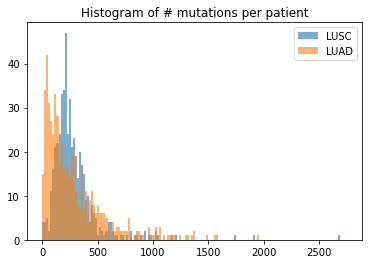

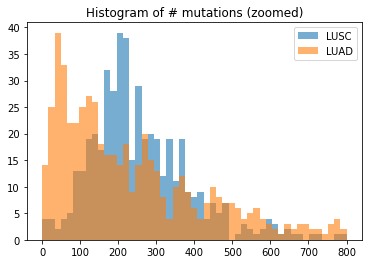

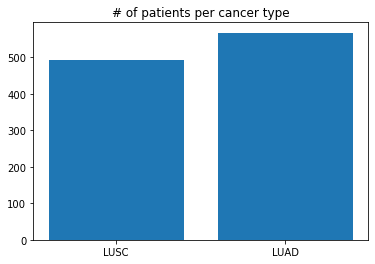

In [2]:
# Looking at the distribution of the mutations

from matplotlib import pyplot as plt
import h5py
import numpy as np
import os
from os.path import isfile, join

types = ["LUSC", "LUAD"]

dataroot = "/mnt/home/sgolkar/projects/cancer-net/data/lung/raw/"

cancer_types = {type: [] for type in types}
num_mutations = {type: [] for type in types}
error_samples = {type: [] for type in types}
sample_IDs = {type: [] for type in types}
nodata = {type: [] for type in types}
for type in types:
    datapath = dataroot + type
    files = [
        join(datapath, f) for f in os.listdir(datapath) if isfile(join(datapath, f))
    ]
    for file in files:
        with h5py.File(file, "r") as f:

            try:
                cancer_types[type].append(f["label"]["sample_meta"]["tumor"][()])
                num_mutations[type].append(len(f["meta"]["mutated_gene_list"][()]))
                sample_IDs[type].append(f["label"]["sample_id"][()])
                if "data" not in f.keys():
                    nodata[type].append(file)
            except:
                error_samples[type].append(file)

# The reference gene file is the only one that errors out
print("Error files: ", error_samples)

# Types of cancer per folder:
print(
    "Cancer types per folder files numbers:",
    {key: len(set(value)) for key, value in cancer_types.items()},
)

print(
    "Duplicates per type:",
    {key: len(set(value)) - len(value) for key, value in sample_IDs.items()},
)

print("Samples without data: ", nodata)


[
    plt.hist(value, bins=np.linspace(0, 2750, 150), label=key, alpha=0.6)
    for key, value in num_mutations.items()
]
plt.title("Histogram of # mutations per patient")
plt.legend()
plt.show()

[
    plt.hist(value, bins=np.linspace(0, 800, 50), label=key, alpha=0.6)
    for key, value in num_mutations.items()
]
plt.title("Histogram of # mutations (zoomed)")
plt.legend()
plt.show()

plt.bar(cancer_types.keys(), [len(el) for el in cancer_types.values()])
plt.title("# of patients per cancer type")
plt.show()

Processing...


loading gene graph took 153.85 seconds.


read samples:   6%|▌         | 59/1059 [01:44<27:32,  1.65s/it]WARNING:root:Cannot load sample file: /mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUSC/TCGA-98-A53C-01A-11D-A25L-08.h5.


invalid sample: /mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUSC/TCGA-98-A53C-01A-11D-A25L-08.h5


read samples: 100%|██████████| 1059/1059 [30:15<00:00,  1.71s/it]


Loading dataset took 1815.61 seconds.
Caching processed dataset...
 done (took 1.63 seconds).
Full processing pipeline took 1971.46 seconds.


Done!


Epoch: 10, Loss: 0.0694, Train Acc: 0.5257
valid Loss: 0.0687, Acc: 0.5733
Epoch: 20, Loss: 0.065, Train Acc: 0.5622
valid Loss: 0.0688, Acc: 0.5267
Epoch: 30, Loss: 0.0604, Train Acc: 0.6257
valid Loss: 0.0698, Acc: 0.5333
Epoch: 40, Loss: 0.059, Train Acc: 0.6486
valid Loss: 0.0708, Acc: 0.5467
Epoch: 50, Loss: 0.0559, Train Acc: 0.6662
valid Loss: 0.0682, Acc: 0.6000
Epoch: 60, Loss: 0.0546, Train Acc: 0.6824
valid Loss: 0.0807, Acc: 0.6000
Epoch: 70, Loss: 0.0515, Train Acc: 0.7014
valid Loss: 0.0805, Acc: 0.6333
Epoch: 80, Loss: 0.0509, Train Acc: 0.7270
valid Loss: 0.0809, Acc: 0.6600
Epoch: 90, Loss: 0.0503, Train Acc: 0.7230
valid Loss: 0.0864, Acc: 0.6533
Epoch: 100, Loss: 0.0502, Train Acc: 0.6986
valid Loss: 0.089, Acc: 0.6400


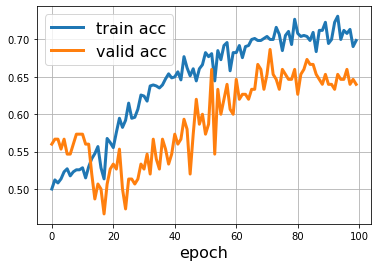

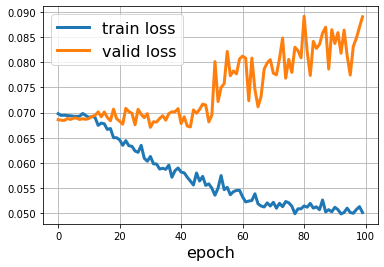

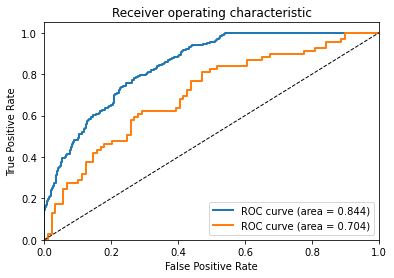

In [3]:
# Training on lung using GCN architecture

# Hyperparameters etc:

arch = "GCN"
batch = 10
parall = False
lr = 0.005


import sys

sys.path.insert(0, "..")
import TCGAData
import torch, torch_geometric.transforms as T, torch.nn.functional as F
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from arch.net import *

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

root = "/mnt/home/sgolkar/projects/cancer-net/data/lung"
files = "/mnt/home/sgolkar/projects/cancer-net/data/lung/samples.txt"
label_mapping = ["LUAD", "LUSC"]
dataset = TCGAData.TCGADataset(
    root=root,
    files=files,
    label_mapping=label_mapping,
    gene_graph="global.geneSymbol.gz",
)


train_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)


model = GCNNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = F.nll_loss


def train(epoch, report=True):
    model.train()

    if epoch == 30:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.5

    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.1

    total_loss = 0
    correct = 0
    num_samps = 0
    for data in train_loader:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss
        loss.backward()
        optimizer.step()
        num_samps += len(y)
    if report:
        print(
            "Epoch: {:02d}, Loss: {:.3g}, Train Acc: {:.4f}".format(
                epoch, total_loss / num_samps, correct / num_samps
            )
        )

    return total_loss / num_samps, correct / num_samps


def valid():
    model.eval()
    correct = 0

    total_loss = 0
    num_samps = 0
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item()

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps


train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
for epoch in range(1, 101):
    report = (epoch) % 10 == 0
    train_loss, train_acc = train(epoch, report=report)
    valid_loss, valid_acc = valid()
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

plt.figure()
plt.plot(train_acces, label="train acc", linewidth=3)
plt.plot(valid_acces, label="valid acc", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()
plt.plot(train_losses, c="tab:blue", label="train loss", linewidth=3)
plt.plot(valid_losses, c="tab:orange", label="valid loss", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_train, tpr_train, _ = roc_curve(ys, outs[:, 1])
train_auc = auc(fpr_train, tpr_train)

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
valid_auc = auc(fpr_valid, tpr_valid)

plt.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
plt.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Processing...


loading gene graph took 174.15 seconds.


read samples:   6%|▌         | 59/1059 [01:50<27:48,  1.67s/it]  WARNING:root:Cannot load sample file: /mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUSC/TCGA-98-A53C-01A-11D-A25L-08.h5.


invalid sample: /mnt/home/sgolkar/projects/cancer-net/data/lung/raw/LUSC/TCGA-98-A53C-01A-11D-A25L-08.h5


read samples: 100%|██████████| 1059/1059 [29:57<00:00,  1.70s/it]


Loading dataset took 1797.80 seconds.
Pre-transforming took 3.68 seconds.
Caching processed dataset...
 done (took 21.69 seconds).
Full processing pipeline took 1997.46 seconds.


Done!


Epoch: 10, Loss: 0.0777, Train Acc: 0.5027
valid Loss: 0.0733, Acc: 0.5733
Epoch: 20, Loss: 0.0599, Train Acc: 0.7000
valid Loss: 0.0678, Acc: 0.6667
Epoch: 30, Loss: 0.053, Train Acc: 0.7189
valid Loss: 0.0663, Acc: 0.6733
Epoch: 40, Loss: 0.0395, Train Acc: 0.8311
valid Loss: 0.0941, Acc: 0.5933
Epoch: 50, Loss: 0.0415, Train Acc: 0.8230
valid Loss: 0.069, Acc: 0.6600
Epoch: 60, Loss: 0.0255, Train Acc: 0.8986
valid Loss: 0.0987, Acc: 0.6733
Epoch: 70, Loss: 0.0124, Train Acc: 0.9554
valid Loss: 0.105, Acc: 0.6467
Epoch: 80, Loss: 0.0115, Train Acc: 0.9608
valid Loss: 0.127, Acc: 0.6333
Epoch: 90, Loss: 0.00953, Train Acc: 0.9689
valid Loss: 0.13, Acc: 0.6667
Epoch: 100, Loss: 0.00732, Train Acc: 0.9716
valid Loss: 0.139, Acc: 0.6667


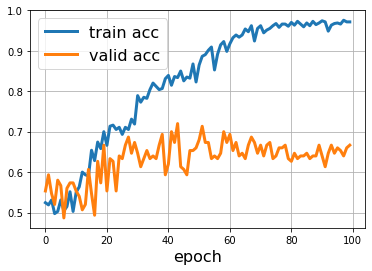

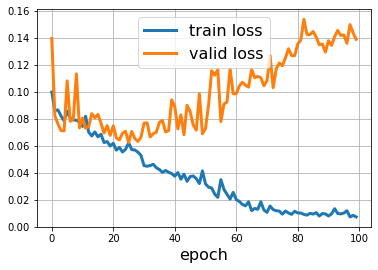

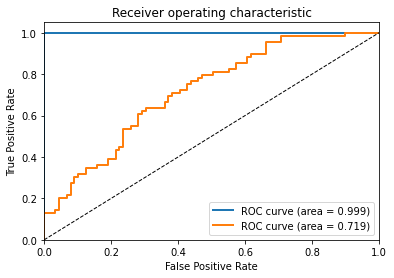

In [4]:
# Training on lung data using GCN2 architecture

# Hyperparameters etc:

arch = "GCN2"
batch = 10
parall = False
lr = 0.005


import sys

sys.path.insert(0, "..")
import TCGAData
import torch, torch_geometric.transforms as T, torch.nn.functional as F
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from arch.net import *

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

root = "/mnt/home/sgolkar/projects/cancer-net/data/lung"
files = "/mnt/home/sgolkar/projects/cancer-net/data/lung/samples.txt"
label_mapping = ["LUAD", "LUSC"]

pre_transform = T.Compose([T.GCNNorm(), T.ToSparseTensor()])
dataset = TCGAData.TCGADataset(
    root=root,
    files=files,
    label_mapping=label_mapping,
    gene_graph="global.geneSymbol.gz",
    pre_transform=pre_transform,
    suffix="sparse",
)


train_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

model = GCN2Net(
    hidden_channels=2048,
    num_layers=4,
    alpha=0.5,
    theta=1.0,
    shared_weights=False,
    dropout=0.2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = F.nll_loss


def train(epoch, report=True):
    model.train()

    if epoch == 30:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.5

    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.1

    total_loss = 0
    correct = 0
    num_samps = 0
    for data in train_loader:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss
        loss.backward()
        optimizer.step()
        num_samps += len(y)
    if report:
        print(
            "Epoch: {:02d}, Loss: {:.3g}, Train Acc: {:.4f}".format(
                epoch, total_loss / num_samps, correct / num_samps
            )
        )

    return total_loss / num_samps, correct / num_samps


def valid():
    model.eval()
    correct = 0

    total_loss = 0
    num_samps = 0
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item()

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps


train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
for epoch in range(1, 101):
    report = (epoch) % 10 == 0
    train_loss, train_acc = train(epoch, report=report)
    valid_loss, valid_acc = valid()
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

plt.figure()
plt.plot(train_acces, label="train acc", linewidth=3)
plt.plot(valid_acces, label="valid acc", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()
plt.plot(train_losses, c="tab:blue", label="train loss", linewidth=3)
plt.plot(valid_losses, c="tab:orange", label="valid loss", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()

# Figuring out the AUC
loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_train, tpr_train, _ = roc_curve(ys, outs[:, 1])
train_auc = auc(fpr_train, tpr_train)

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
valid_auc = auc(fpr_valid, tpr_valid)

plt.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
plt.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()